In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import lib.snn as snn
import lib.spikeFileIO as io
import zipfile
import os
from lib.datasets.mnistdataset import SMNIST
from IPython.display import HTML



In [2]:
# CONSTANTS

USE_CUDA = torch.cuda.is_available()
#


In [3]:

netParams = snn.params('data/mnist/network.yaml')
print(netParams)

In [4]:

# Network definition
class Network(torch.nn.Module):
    def __init__(self, netParams):
        super(Network, self).__init__()
        # initialize slayer
        slayer = snn.layer(netParams['neuron'], netParams['simulation'])
        self.slayer = slayer
        # define network functions
        # self.conv1 = slayer.conv(1, 16, 5, padding=1)
        # self.conv2 = slayer.conv(16, 32, 3, padding=1)
        # self.conv3 = slayer.conv(32, 64, 3, padding=1)
        # self.pool1 = slayer.pool(2)
        # self.pool2 = slayer.pool(2)
        self.fc1   = slayer.dense((28, 28, 1), 512)
        # self.fc1 = slayer.dense((34 * 34 * 2), 512)
        self.fc2 = slayer.dense(512, 10)

    def forward(self, spikeInput):
        spikeLayer1 = self.slayer.spike(self.slayer.psp(self.fc1(spikeInput)))
        spikeLayer2 = self.slayer.spike(self.slayer.psp(self.fc2(spikeLayer1)))

        return spikeLayer2
        # spikeLayer1 = self.slayer.spike(self.conv1(self.slayer.psp(spikeInput ))) # 32, 32, 16
        # spikeLayer2 = self.slayer.spike(self.pool1(self.slayer.psp(spikeLayer1))) # 16, 16, 16
        # spikeLayer3 = self.slayer.spike(self.conv2(self.slayer.psp(spikeLayer2))) # 16, 16, 32
        # spikeLayer4 = self.slayer.spike(self.pool2(self.slayer.psp(spikeLayer3))) #  8,  8, 32
        # spikeLayer5 = self.slayer.spike(self.conv3(self.slayer.psp(spikeLayer4))) #  8,  8, 64
        # spikeOut    = self.slayer.spike(self.fc1  (self.slayer.psp(spikeLayer5))) #  10
        #
        # return spikeOut

In [5]:
# INITIALIZATION 


device = torch.device("cuda" if USE_CUDA else "cpu")

#Create network instance.
net = Network(netParams).to(device)

# Create snn loss instance.
error = snn.loss(netParams).to(device)

# Define optimizer module.
optimizer = torch.optim.Adam(net.parameters(), lr = 0.01, amsgrad = True)

# Dataset and dataLoader instances.
trainingSet = SMNIST(datasetPath =netParams['training']['path']['in'],
                            samplingTime=netParams['simulation']['Ts'],
                            sampleLength=netParams['simulation']['tSample'])
trainLoader = DataLoader(dataset=trainingSet, batch_size=8, shuffle=False, num_workers=4)

testingSet = SMNIST(datasetPath  =netParams['training']['path']['in'],
                            samplingTime=netParams['simulation']['Ts'],
                            sampleLength=netParams['simulation']['tSample'])
testLoader = DataLoader(dataset=testingSet, batch_size=2, shuffle=False, num_workers=4)

# Learning stats instance.
stats = snn.learningStats()

In [6]:
## VISUALIZATION

input, target, label = trainingSet[0]
anim = io.animTD(io.spikeArrayToEvent(input.reshape((1, 28, 28, -1)).cpu().data.numpy()))
HTML(anim.to_jshtml())



In [7]:
## Training

# training loop
for epoch in range(100):
    # Reset training stats.
    stats.training.reset()
    tSt = datetime.now()
    
    # Training loop.
    for i, (input, target, label) in enumerate(trainLoader, 0):
        # Move the input and target to correct GPU.
        input = input.to(device)
        target = target.to(device)

        # Forward pass of the network.
        output = net.forward(input)

        # Gather the training stats.
        stats.training.correctSamples += torch.sum(snn.predict.getClass(output) == label).data.item()
        stats.training.numSamples += len(label)

        # Calculate loss.
        loss = error.numSpikes(output, target)

        # Reset gradients to zero.
        optimizer.zero_grad()

        # Backward pass of the network.
        loss.backward()

        # Update weights.
        optimizer.step()

        # Gather training loss stats.
        stats.training.lossSum += loss.cpu().data.item()

        # Display training stats.
        # if i%10 == 0: stats.print(epoch, i, (datetime.now() - tSt).total_seconds())
    # Update training stats.
    stats.training.update()
    # Reset testing stats.
    stats.testing.reset()
    # Testing loop.
    # Same steps as Training loops except loss backpropagation and weight update.
    for i, (input, target, label) in enumerate(testLoader, 0):
        input = input.to(device)
        target = target.to(device)

        output = net.forward(input)

        stats.testing.correctSamples += torch.sum(snn.predict.getClass(output) == label).data.item()
        stats.testing.numSamples += len(label)

        loss = error.numSpikes(output, target)
        stats.testing.lossSum += loss.cpu().data.item()
        
        # if i%10 == 0: stats.print(epoch, i)


    # Update stats.
    stats.testing.update()
    if epoch%10==0:  stats.print(epoch, timeElapsed=(datetime.now() - tSt).total_seconds())


Epoch :          0,   11748.0990 ms elapsed
loss = 9.8902       (min = 9.8902      )  	accuracy = 0.1        (max = 0.1       )
loss = 7.965        (min = 7.965       )  	accuracy = 0.122      (max = 0.122     )

Epoch :         10,   11821.0090 ms elapsed
loss = 7.7736       (min = 7.5404      )  	accuracy = 0.106      (max = 0.122     )
loss = 7.5          (min = 7.4876      )  	accuracy = 0.108      (max = 0.128     )

Epoch :         20,   12167.7080 ms elapsed
loss = 7.0755       (min = 7.0755      )  	accuracy = 0.138      (max = 0.138     )
loss = 6.1381       (min = 6.1381      )  	accuracy = 0.13       (max = 0.13      )

Epoch :         30,   11499.5800 ms elapsed
loss = 4.741        (min = 4.741       )  	accuracy = 0.216      (max = 0.216     )
loss = 4.6645       (min = 4.6108      )  	accuracy = 0.226      (max = 0.226     )

Epoch :         40,   11954.3420 ms elapsed
loss = 5.1739       (min = 4.1488      )  	accuracy = 0.12       (max = 0.424     )
loss = 4.981       

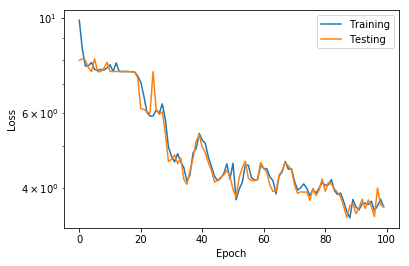

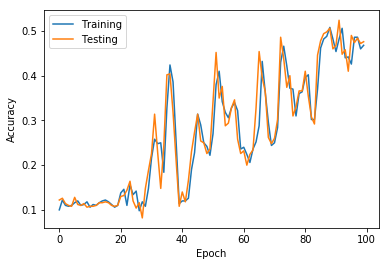

In [8]:
# Plot the results.
plt.figure(1)
plt.semilogy(stats.training.lossLog, label='Training')
plt.semilogy(stats.testing.lossLog, label='Testing')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.figure(2)
plt.plot(stats.training.accuracyLog, label='Training')
plt.plot(stats.testing.accuracyLog, label='Testing')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [9]:
for k in iter(net.state_dict()):
    print("Layer {}".format(k))
    print(net.state_dict()[k].shape)

Layer slayer.srmKernel
torch.Size([77])
Layer slayer.refKernel
torch.Size([11])
Layer fc1.weight
torch.Size([512, 1, 28, 28, 1])
Layer fc2.weight
torch.Size([10, 512, 1, 1, 1])
